# Site Occupation Embedding Theory
---------------------------------------------------------

A basic implementation of Site Occupation Embedding Theory following the three papers:
    1. Mol. Phys. 115 (2017) 48
    2. PRB 97 (2018) 235105
    3. TCA 137:169 (2018)

## I. Preliminaries

The Hubbard model in 1D is the toy model to play with SOET and test the implementation. The Hubbard model is written as :

$$
\hat{H} = -t \sum^{N-1}_{i=1} \sum_{\sigma} \left( \hat{c}^{\dagger}_{i,\sigma}\hat{c}_{i+1,\sigma} + h.c. \right) + U \sum^N_{i=1} \left( \hat{n}_{\uparrow,i}\hat{n}_{\downarrow,i}\right) + \sum^N_{i=1}\nu_i \hat{n}_i
$$

The operators $\sum_{\sigma}\hat{c}^{\dagger}$ and $\sum_{\sigma}\hat{c}_{\sigma}$ are 4x4 matrices given by:
$$
\sum_{\sigma}\hat{c}^{\dagger}_{\sigma} = \begin{array}{|c|c|c|c|}
\hline
0&0&0&0\\ \hline
1&0&0&0\\ \hline
1&0&0&0\\ \hline
0&1&1&0\\ \hline
 \hline
\end{array}
$$
and $\sum_{\sigma}\hat{c}_{\sigma}$ is given by:
$$
\sum_{\sigma}\hat{c}_{\sigma} = \begin{array}{|c|c|c|c|}
\hline
0&1&1&0\\ \hline
0&0&0&1\\ \hline
0&0&0&1\\ \hline
0&0&0&0\\ \hline
 \hline
\end{array}
$$

The occupation number operator $\hat{n}$ is diagonal and written in matrix form as:
$$
\sum_{\sigma}\hat{n}_{\sigma} = \begin{array}{|c|c|c|c|}
\hline
0&0&0&0\\ \hline
0&1&0&0\\ \hline
0&0&1&0\\ \hline
0&0&0&2\\ \hline
 \hline
\end{array}
$$

Using these definitions and the ratio $U/t$ and $\nu/t$ with the unit of $t$ taken as 1, one can setup the Hubbard Hamiltonian and solve for the ground states.

### 1. Hubbard dimer

Consider the minimal model with two orbitals and two electrons.

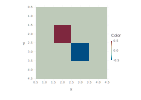

In [27]:
# define standard operators
using SparseArrays
using LinearAlgebra
using Arpack
using Plots
using Arpack
using Gadfly

# Creation (Cre) and Destruction (Des) Ms summed operators
Cre = SparseArrays.sparse(1.0*LinearAlgebra.Diagonal(zeros(4)));
Cre[2,1]=1.0;
Cre[3,1]=1.0;
Cre[4,2]=Cre[4,3]=1.0;
Des = SparseArrays.sparse(transpose(Cre));

# Creation (Cre) and Destruction (Des) Ms dependent operators
CreUp = SparseArrays.sparse(1.0*LinearAlgebra.Diagonal(zeros(4)));
CreUp[2,1]=1.0;
CreUp[4,3]=1.0;
DesUp = SparseArrays.sparse(transpose(CreUp));
CreDn = SparseArrays.sparse(1.0*LinearAlgebra.Diagonal(zeros(4)));
CreDn[3,1]=1.0;
CreDn[4,2]=1.0;
DesDn = SparseArrays.sparse(transpose(CreDn));

# electron number operator (Num)
Num = SparseArrays.sparse(1.0*LinearAlgebra.Diagonal(ones(4)));
Num[1,1]=0.0;
Num[2,2]=1.0;
Num[3,3]=1.0;
Num[4,4]=2.0;

# up (Numup) and down (Numdn) electron counters
Numup = SparseArrays.sparse(1.0*LinearAlgebra.Diagonal(ones(4)));
Numup[1,1]=0.0;
Numup[2,2]=1.0;
Numup[3,3]=0.0;
Numup[4,4]=1.0;
Numdn = SparseArrays.sparse(1.0*LinearAlgebra.Diagonal(ones(4)));
Numdn[1,1]=0.0;
Numdn[2,2]=0.0;
Numdn[3,3]=1.0;
Numdn[4,4]=1.0;

# Identity operator
Eye = SparseArrays.sparse(1.0*LinearAlgebra.Diagonal(ones(4)));

# Sz operator
Sz = 0.5 * Numup - 0.5 * Numdn


Gadfly.spy(Matrix(Sz))

In [28]:
# build the Hamiltonian

# on site 1
CreUp1 = kron(CreUp,Eye);
CreDn1 = kron(CreDn,Eye);
Num1 = kron(Num,Eye);
Numup1 = kron(Numup,Eye);
Numdn1 = kron(Numdn,Eye);
Sz1 = kron(Sz,Eye);
Eye1 = kron(Eye,Eye);

# on site 2
DesUp2 = kron(Eye,DesUp);
DesDn2 = kron(Eye,DesDn);
Num2 = kron(Eye,Num);
Numup2 = kron(Eye,Numup);
Numdn2 = kron(Eye,Numdn);
Sz2 = kron(Eye,Sz);
Eye2 = Eye1;

# make the Hamiltonian
t=1.0;
U=4.0t;
U1=4.0t;
U2=4.0t;
ν=0.1t;
ν1=0.1t;
ν2=0.1t;
ϵ=10^-10;
dimHam = 4^2;

Ham = -t*(CreUp1*DesUp2 + CreDn1*DesDn2 + transpose(CreUp1*DesUp2 + CreDn1*DesDn2)) + U1*(Numup1*Numdn1) + U2*(Numup2*Numdn2) + ν1*(Num1) + ν2*(Num2);

# extract the relavant n̂ zone
nel=2.0;
Idxs = getRelavantIdxs(Num1 + Num2, nel);
print("Idxs=",Idxs)
HamTrunc = projectHamiltonian(dimHam,Ham,Idxs);
SzTrunc = projectHamiltonian(dimHam,Sz1+Sz2,Idxs)
dim = size(HamTrunc);


# extract the relavant Ŝz zone
Sz = 0.0
Idxs = getRelavantIdxs(SzTrunc, Sz);
dimHtrunc = size(HamTrunc)[1];
HamTrunc2 = projectHamiltonian(dimHtrunc,HamTrunc,Idxs)

λ,ψ = Arpack.eigs(HamTrunc2, nev=1, which=:SR)
λ=real(λ);
ψ=real(ψ);
ψ[map.(abs,ψ) .< ϵ].=0.0;
print("Energy=",λ)
Matrix(HamTrunc2)

Idxs=[1, 2, 3, 5, 8, 9, 12, 14, 15, 16]Energy=[-0.6284271247461897]

4×4 Array{Float64,2}:
  4.2  -1.0  -1.0   0.0
 -1.0   0.2   0.0  -1.0
 -1.0   0.0   0.2  -1.0
  0.0  -1.0  -1.0   4.2

# II. Analytic results

As we see above, the Hubbard Hamiltonian is quite simple for the $$<\hat{n}>=2$$ subspace. There are essentially three types of basis functions one with [2 0] occuaption another with [0 2] (with indices 1 and 6 respectively) and the four basis functions in the middle represent the Ms=1,0(S=1),0(S=0),-1 basis functions respectively. 

The above matrix can also be written analytically as:
$$
\hat{H}_{<\hat{n}>=2} = \begin{array}{|c|c|c|c|}
\hline
U_0+2\nu_0&-t&-t&0\\ \hline
-t&\nu_0+\nu_1&0&-t\\ \hline
-t&0&\nu_0+\nu_1&-t\\ \hline
0&-t&-t&U_1+2\nu_1\\ \hline
 \hline
\end{array}
$$

This Hamiltonian can be simplified by projecting the basis onto the S=0 spin subspace and upon taking $\frac{a\bar{b}-\bar{a}b}{\sqrt{2}}$ as one S=0 eigenfunction we get the same result as that of the paper (Eq.26):

$$
\hat{H}_{<\hat{n}>=2,S=0} = \begin{array}{|c|c|c|}
\hline
U_0+2\nu_0&-\sqrt{2}t&0\\ \hline
-\sqrt{2}t&\nu_0 + \nu_1&-\sqrt{2}t\\ \hline
0&-\sqrt{2}t&U_1+2\nu_1\\ \hline
 \hline
\end{array}
$$

## 1. Energy Functional

Here we will analyze the energy funtional and its relation to $U/t$ and $\nu/t$.

Analytic results can be found in the case of two site Hubbard model. First, we shall rewrite the above Hamiltonian in a simplified form under the assumption $\nu_1 + \nu_2 = 0$ as follows:

$$
\hat{H}_{<\hat{n}>=2,S=0} = \begin{array}{|c|c|c|}
\hline
U_0+\delta\nu&-\sqrt{2}t&0\\ \hline
-\sqrt{2}t&0&-\sqrt{2}t\\ \hline
0&-\sqrt{2}t&U_1-\delta\nu\\ \hline
 \hline
\end{array}
$$

And we obtain the same matrix as in Eq(26). Analytic diagonalization can be carried out with the assumption that $U_0 = U_1 = U$. 

One root is then written as follows:

$$
\frac{\sqrt[3]{\sqrt{4 \left(18 t^2 U+U^3-9 U v^2\right)^2-4 \left(12 t^2+U^2+3 v^2\right)^3}-36 t^2 U-2 U^3+18 U v^2}}{3 \sqrt[3]{2}}\\+\frac{\sqrt[3]{2} \left(12 t^2+U^2+3 v^2\right)}{3 \sqrt[3]{\sqrt{4 \left(18 t^2 U+U^3-9 U v^2\right)^2-4 \left(12 t^2+U^2+3 v^2\right)^3}-36 t^2 U-2 U^3+18 U v^2}}+\frac{2 U}{3}
$$

with the substitution of variable $u = U/2t$, $v=\nu/2t$ and $w=\sqrt{3\left(1 + \nu^2 \right) + u^2}$, we obtain the expression given in the Eqs 27 of paper I.

$$
E(U,\delta\nu) = \frac{4t}{3}\left( u - w \sin\left( \theta + \frac{\pi}{6}\right)\right)
$$

Using this result, the energy functional of the general Hamiltonian shown above can be found by using the following two relations:

$$
U = \frac{U_0 + U_1}{2}
$$

and

$$
\delta\nu_{eff} = \delta\nu + \frac{U_1 - U_0}{2}
$$

Then we get the final energy functional in terms of the general interaction parameters:

$$
\mathcal{E}(U_0,U_1,\delta\nu) = E((U_0+U_1)/2,\delta\nu + (U_1 - U_0)/2))
$$

## 2. Levy-Lieb Functional and $E_c$

The Levy-Lieb Functional is the equivalent of the Hohenberg-Kohn function in SOET and is a function of $t$ and $U$. The general definition of LL Functional gives the energy as a function of site occupation ($n$) and is as follows:

$$
F(U,\textbf{n}) = \sup_{v}\left\{ E(v) - <v|n> \right\}
$$

The Kohn-Sham formulation of SOFT gives the following partitioning of the exchange and correlation:

$$
F(U,\textbf{n}) = \mathcal{T}_s(\textbf{n}) + E_{Hxc}(U,\textbf{n})
$$

where $E_{Hxc}(U,\textbf{n}) = E_{Hx}(U,\textbf{n}) + E_c(U,\textbf{n})$.

From here one can obtain the correlation energy after using the definition of the Hartree exchange energy as:

$$
E_{Hx} = \frac{U}{4}\sum_i \left( n^2_i \right)
$$

The total correlation energy $E_c$ is:

$$
E_c(U,\textbf{n}) = F(U,\textbf{n})-\mathcal{T}_s(\textbf{n})-E_{Hx}(U,\textbf{n})
E_c(U,\textbf{n}) = F(U,\textbf{n})-\mathcal{T}_s(\textbf{n})-\frac{U}{4}\left( n^2_0 + n^2_1\right)
$$

The kinetic energy of the non-interacting system is given by:

$$
\mathcal{T}_s(n) = -2t\sqrt(n(2-n))
$$

## 3. Impurity correlation energy ($E^{imp}_c$)

The energy functional for the impurity and the system have the following relationship:

$$
\mathcal{E}^{imp}(U,\delta\nu) = \mathcal{E}(U,0,\delta\nu) = E(U/2,\delta\nu - U/2)
$$

where we've basically substituted used $U_1=0$ for the impurity energy.

Using the LL functional for the impurity gives the impurity correlation energy as follows:

$$
F^{imp}(U,\textbf{n}) = \sup_{v}\left\{ \mathcal{E}^{imp}(v) - <v|n> \right\}
$$

using the relation between the energies above this becomes:

$$
F^{imp}(U,\textbf{n}) = F(U/2\textbf{n}) + \frac{U}{2}(n-1)
$$


Now we can define the correlation energy of the impurity using the LL function for the impurity as follows

$$
E^{imp}_c(U,n) = F^{imp}(U,n) - \mathcal{T}_s(n) - E^{imp}_{Hx}(U,n)
$$

with $E^{imp}_{Hx}(U,n) = \frac{U}{4}n^2$

Therefore $E^{imp}_c$ can be obtained by $E_c$ by scaling by $\frac{1}{2}$ the U parameter:

$$
E_c(U,n) = E^{imp}_c(U/2,n)
$$

In [21]:
# Plot of the "exact" correlation energy  $E_c$

"""
Calculate the energy of a two site
Hubbard model with t, U and ν.
"""
function hubbardDimerEnergy(U,ν,t)
    u=U/(2t)
    v=ν/(2t)
    w=sqrt(3.0 * (1 + v^2) + u^2)
    θ = (1/3)*acos((9(v^2 - 0.5)-u^2)*(u/w^3))
    return((4t/3)*(u-w*sin(θ + π/6)))
end
res=zeros(10,3)
count=1
for u in 1:10
    res[count,1]=hubbardDimerEnergy(u,0.1,0.5)
    res[count,2]=hubbardDimerEnergy(5u,0.1,0.5)
    res[count,3]=hubbardDimerEnergy(10u,0.1,0.5)
    count+=1
end
plot(1:10,res)

UndefVarError: UndefVarError: plot not defined

## 4. Plots

### a.) $F(U,\nu,n)$ vs $\delta\nu$

$$
F(U,\nu,n) = \sup_{\nu}\left\{ E(U,\nu) + \delta\nu \times (n-1)\right\}
$$

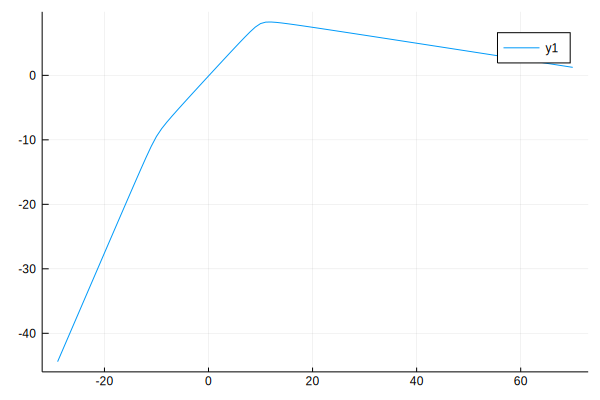

In [31]:
using Optim

"""
Maximize the Levy-Lieb Functional F(U,n)
"""
function FUn(U,ν,n)
    FUn = hubbardDimerEnergy(U,ν,0.5) + ν*(n-1)
    return FUn
end
dim=100
res=zeros(dim)
x=zeros(dim)
count=1
for u in 1:dim
    ν=(u-30)*1
    x[count]=ν
    res[count]=FUn(10.,ν,15/8)
    count+=1
end
Plots.plot(x,res)

Maximize $F_{LL}(U,\nu)$

In [23]:
"""
Maximize the Levy-Lieb Function FUn 
and return the ν which corresponds to the maximum value.
"""
function maximizeFUn(U,n)
    function f_univariate(ν)
        return -FUn(U,ν,n)
    end
    res=optimize(f_univariate, -U*5,U*5)
    return(Optim.minimizer(res))
end
maximizeFUn(10.,15/8)

11.6268943344521

### b.) $E_c$ vs $\textbf{n}$

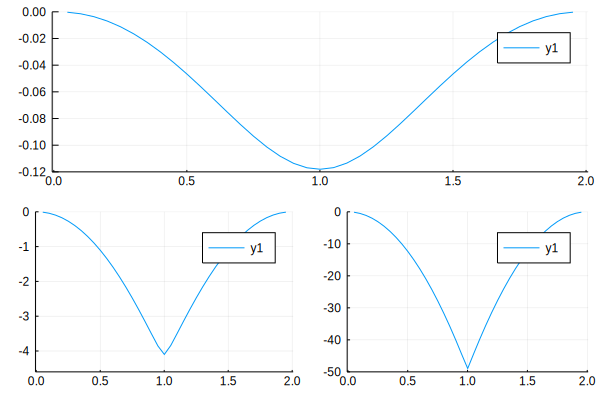

In [33]:
"""
Calculate the correlation energy of 
the Hubbard model using Eq 40.
"""
function corrEnergy(U,t,n)
    Ts = -2t*sqrt(n*(2-n))
    EHx = U*(1-(n*(2-n)/2))
    ν = maximizeFUn(U,n)
    FUn = hubbardDimerEnergy(U,ν,t) + ν*(n-1)
    return(FUn-Ts-EHx)
end
res=zeros(4*11-1,3)
xaxis=zeros(4*11-1)
count=1
for n in 0.001:0.05:1.999
    res[count,1]=corrEnergy(1.0,0.5,n)
    res[count,2]=corrEnergy(10.0,0.5,n)
    res[count,3]=corrEnergy(100.0,0.5,n)
    xaxis[count]=n
    count+=1
end
p1=Plots.plot(xaxis[2:40],res[2:40,1],ylims=(-0.12,0))
p2=Plots.plot(xaxis[2:40],res[2:40,2],ylims=(-4.6,0))
p3=Plots.plot(xaxis[2:40],res[2:40,3],ylims=(-50.0,0))
l = @layout [a; b c]
Plots.plot(p1,p2,p3,layout=l)

### c.) $E_c$ and $E^{imp}_c$ vs $\textbf{n}$

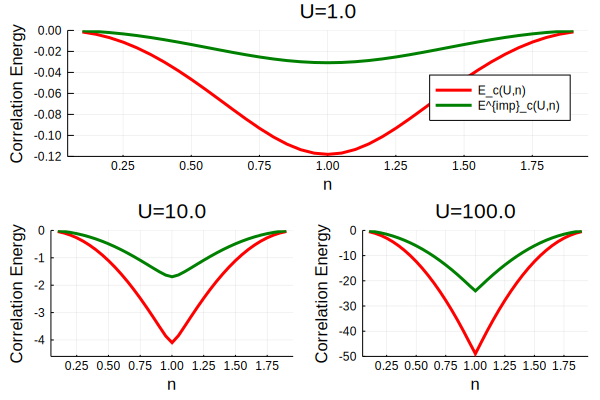

In [35]:
"""
Calculate the correlation energy of
the impurity.
"""
function corrEnergyImp(U,t,n)
    Ts = -2t*sqrt(n*(2-n))
    EHxImp = (U/4)*n*n
    ν = maximizeFUn(U/2,n)
    FUnImp = ( hubbardDimerEnergy(U/2,ν,t)  + ν*(n-1) ) + (U/2)*(n-1)
    return(FUnImp-Ts-EHxImp)
end
res=zeros(4*11-1,6)
xaxis=zeros(4*11-1)
count=1
for n in 0.001:0.05:1.999
    res[count,1]=corrEnergy(1.0,0.5,n)
    res[count,3]=corrEnergy(10.0,0.5,n)
    res[count,5]=corrEnergy(100.0,0.5,n)
    res[count,2]=corrEnergyImp(1.0,0.5,n)
    res[count,4]=corrEnergyImp(10.0,0.5,n)
    res[count,6]=corrEnergyImp(100.0,0.5,n)
    xaxis[count]=n
    count+=1
end
p1=Plots.plot(xaxis[3:39],res[3:39,1:2],title="U=1.0",ylims=(-0.12,0),ylabel="Correlation Energy",xlabel="n",label=["E_c(U,n)" "E^{imp}_c(U,n)"],lw=3,color=[:red :green],legend=:bottomright)
p2=Plots.plot(xaxis[3:39],res[3:39,3:4],title="U=10.0",ylims=(-4.6,0),ylabel="Correlation Energy",xlabel="n",legend=false,lw=3,color=[:red :green])
p3=Plots.plot(xaxis[3:39],res[3:39,5:6],title="U=100.0",ylims=(-50.0,0),ylabel="Correlation Energy",xlabel="n",legend=false,lw=3,color=[:red :green])
l = @layout [a; b c]
Plots.plot(p1,p2,p3,layout=l)

### d.) Potential vs $\textbf{n}$

The exchange correlation potential $\delta\nu_{Hxc}$ is given by:

$$
\delta\nu_{Hxc}(U,\textbf{n}) = \delta\nu_{Hx}(U,\textbf{n}) - \frac{\partial E_c(U,\textbf{n})}{\partial \textbf{n}}
$$

with $E_c(U,\textbf{n}) = F(U,\textbf{n}) -\mathcal{T}_s(n) - E_{Hx}(U,n)$ the final expression is:

$$
\delta\nu_{Hxc}(U,\textbf{n}) = 2\delta\nu_{Hx}(U,\textbf{n}) - \delta\nu + \frac{2t(n-1)}{\sqrt{n(2-n}} 
$$

where $\delta\nu_{Hx} = U(1-n)$

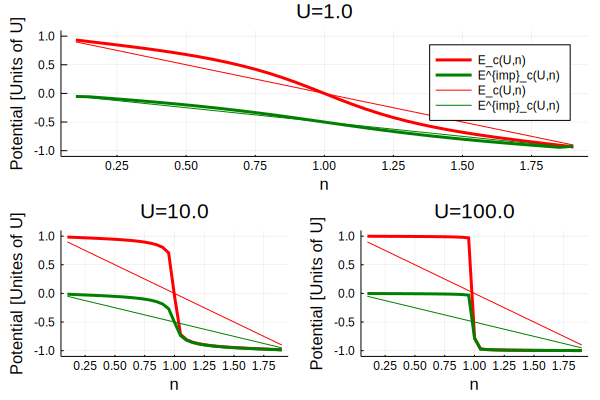

In [36]:
using Calculus

"""
Define function to get the total potential.
"""
function potentialFull(U,n)
    f(x) = corrEnergy(U,0.5,x)
    δE = derivative(f)(n)
    δνHx = U * (1-n)
    return (δνHx - δE)/U
end
"""
Define function to get the impurity potential.
"""
function potentialImp(U,n)
    f(x) = corrEnergyImp(U,0.5,x)
    δE = derivative(f)(n)
    δνHx = -U * n/2
    return (δνHx - δE)/(U)
end
res=zeros(4*11-1,12)
xaxis=zeros(4*11-1)
count=1
for n in 0.001:0.05:1.999
    res[count,1]=potentialFull(1.0,n)
    res[count,5]=potentialFull(10.0,n)
    res[count,9]=potentialFull(100.0,n)
    res[count,2]=potentialImp(1.0,n)
    res[count,6]=potentialImp(10.0,n)
    res[count,10]=potentialImp(100.0,n)
    
    res[count,3]=1.0 * (1-n)
    res[count,7]=1.0 * (1-n)
    res[count,11]=1.0 * (1-n)
    res[count,4]=-1.0 * n/2
    res[count,8]=-1.0 * n/2
    res[count,12]=-1.0 * n/2
    xaxis[count]=n
    count+=1
end
p1=Plots.plot(xaxis[3:39],res[3:39,1:4],title="U=1.0",ylims=(-1.1,1.1),ylabel="Potential [Units of U]",xlabel="n",label=["E_c(U,n)" "E^{imp}_c(U,n)"],lw=[:3 :3 :1 :1],color=[:red :green :red :green],legend=:bottomright)
p2=Plots.plot(xaxis[3:39],res[3:39,5:8],title="U=10.0",ylims=(-1.1,1.1),ylabel="Potential [Unites of U]",xlabel="n",legend=false,lw=[:3 :3 :1 :1],color=[:red :green :red :green])
p3=Plots.plot(xaxis[3:39],res[3:39,9:12],title="U=100.0",ylims=(-1.1,1.1),ylabel="Potential [Units of U]",xlabel="n",legend=false,lw=[:3 :3 :1 :1],color=[:red :green :red :green])
l = @layout [a; b c]
Plots.plot(p1,p2,p3,layout=l)

# II. Impurity Occupationa functional

## 1. ILDA

As a first approximation the impurity correlation functional is assumed to be independent of bath occupations:

$$
E^{imp}_c(\textbf{n}) \rightarrow E^{imp}_c(n_{j_0})
$$

The embedding potential under ILDA is given by:

$$
\nu^{emb}_i = \frac{U}{2}n_i \left( 1-\delta_{ij_0} \right) + \frac{\delta e_c(n_i)}{\delta n_i} -\frac{\delta E^{imp}_c(n_{j_0})}{\delta n_{j_0}}\delta_{ij_0}
$$

Under ILDA, we assume that the bath occupations are the same we shift the potential by $-U n/2 - \delta e_c(n)/\delta n$ to get the approximate ILDA potential:

$$
\nu^{ILDA}_i = -\delta_{ij_0}\left( \frac{U}{2}n_{j_0} +  \frac{\delta E^{imp}_c(n_{j_0})}{\delta n_{j_0}}\right)
$$

This gives the self-consistency equation for the wavefunction as:

$$
\left( \hat{\mathcal{T}}_s + U \hat{n}_{\uparrow j_0}\hat{n}_{\downarrow j_0} - \nu^{ILDA}_{j_0} \right) |\Psi^{imp}> = \mathcal{E}^{imp}|\Psi^{imp}>
$$

which simplifies to:

$$
\left( \hat{\mathcal{T}}_s + U \hat{n}_{j_0\uparrow }\hat{n}_{j_0\downarrow}  -\left[ \frac{U}{2}\hat{n}_{j_0} +  \frac{\delta E^{imp}_c(n_{j_0})}{\delta n_{j_0}}\right]\right) |\Psi^{imp}> = \mathcal{E}^{imp}|\Psi^{imp}>
$$

Now the only thing that needs to be defined is the impurity functional $E_c(n_{ij_0}$ this is defined by an approximation using the 2L Hubbard $E^{imp}_c$ which gives the 2L-ILDA approximate $E^{imp}_c(n_{j_0})$ as:

$$
E^{imp}_c(n_{j_0}) \rightarrow E^{2L}_c(U/2,n_{j_0})
$$

The corresponding Legendre-Fenchel transform gives the equation to solve for the impurity-optimized potential $\nu_{j_0}$ as:

$$
F^{imp}(\textbf{n}) = \sup_{\nu_{j_0}}\left\{ \mathcal{E}^{imp}(\nu_{j_0}) - \nu_{j_0}n_{j_0} \right\}
$$

# III. Hubbard chain results

# 1. 8 sites Hubbard ring

As a first example we try the $L=8$ Hubbard ring at half-filling $N=L=8$.

In [37]:
using BenchmarkTools

# make the Hamiltonian
t=1.0;
U=4.0t;
U1=4.0t;
U2=4.0t;
ν=0.1t;
ν1=0.1t;
ν2=0.1t;
ϵ=10^-10;
Nsites=8;
ntrunc=8;
Sztrunc=0.0;
Ham8sites = makeOps(Nsites,t,U,ν,ntrunc,Sztrunc)

λ,ψ = Arpack.eigs(Ham8sites, nev=1, which=:SR)
λ=real(λ);
ψ=real(ψ);
ψ[map.(abs,ψ) .< ϵ].=0.0;
print("Energy=",λ)


Energy=[-3.4358069991296754]

1. with mapreduce

7.912 s (570645 allocations: 2.54 GiB)
Energy=[-3.4358069991296687]

2. with map and reduce

  8.678 s (570651 allocations: 2.54 GiB)
Energy=[-3.4358069991296665]

---------------------

## Helper Functions and Testing

In [8]:
using TimerOutputs
using Distributed

"""
Get the indices of the Hamiltonian with the relavant number of
electrons.
"""
function getRelavantIdxs(Ham,nel)
    diagham = Ham[LinearAlgebra.diagind(Ham)]
    dim = length(diagham)
    Idxs = (diagham .!= nel)
    Idxs=range(1,length=dim)[Idxs]
    return(Idxs)
end

"""
Remove a row and column from 
an input matrix
"""
function deleteRowCol(A,row,col)
    B = A[1:end .!= row,:]
    C = B[:, 1:end .!= col]
    return(C)
end

"""
Project out the relavant part
of the Hamiltonian
"""
function projectHamiltonian(dimHam, Ham,Idxs)
    dim = length(Idxs)
#    to = TimerOutput()
#    rangedimHam = 1:dimHam;
#    @timeit to "Get Idxs1" IdxsList = map(x->1:dimHam .!= x,Idxs)
#    print(IdxsList,"\n")
#    print(mapfoldl(x->1:dimHam .!=x,(x,y)->x.*y,Idxs),"\n")
#    @timeit to "Get Idxs2" Idxsall = reduce((x,y) -> x.*y,IdxsList)
    
#    IdxsList = map(x->1:dimHam .!= x,Idxs)
#    Idxsall = reduce((x,y) -> x.*y,IdxsList)
    Idxsall = mapfoldl(x->1:dimHam .!=x,(x,y)->x.*y,Idxs);
    A = Ham[Idxsall, Idxsall];
    
#    @timeit to "Al" Idxsall = mapfoldl(x->1:dimHam .!=x,(x,y)->x.*y,Idxs);
#    @timeit to "Allocate" A= Ham[Idxsall, Idxsall];
#    show(to; allocations = false)
#    print(Idxsall)
#    count = 1;
#    for i in 0:dim-1
#        A=deleteRowCol(A,Idxs[i+1]-i,Idxs[i+1]-i)
#        row = Idxs[i+1];
#        col = Idxs[i+1];
#        print(Ham[Idxsall, Idxs[i+1]], "\t",row,"\n");
        
#        count += 1;
#    end
    return(A)
end

projectHamiltonian

In [9]:
tmpHam = rand(4,4)
tmpHam[1,1]=1.0;
tmpHam[2,2]=2.0;
tmpHam[3,3]=1.0;
tmpHam[4,4]=2.0;
Idxs=getRelavantIdxs(tmpHam,1.0)

2-element Array{Int64,1}:
 2
 4

In [10]:
tmpHam

4×4 Array{Float64,2}:
 1.0       0.76813   0.338911  0.0909613
 0.886259  2.0       0.881811  0.0281004
 0.697329  0.796446  1.0       0.211267 
 0.209057  0.174809  0.299469  2.0      

In [11]:
a=projectHamiltonian(4,tmpHam,Idxs)

2×2 Array{Float64,2}:
 1.0       0.338911
 0.697329  1.0     

In [12]:
a

2×2 Array{Float64,2}:
 1.0       0.338911
 0.697329  1.0     

### Taking derivatives

In [13]:
using Calculus

derivative(sin,0.0)

f(x) = exp(-x^2/2)
plot(0.0001:0.01:5,derivative(f))

UndefVarError: UndefVarError: plot not defined

### Building Hamiltonian Operators

#### a.) Sparse vs Full matrices

In [14]:
# Check the size of a sparse matrix vs full matrix

Cre2 = kron(kron(kron(kron(kron(Cre,Eye),Eye),Eye),Eye),Eye)
CreFull = zeros(4,4);
CreFull[2,1]=1.0;
CreFull[3,1]=1.0;
CreFull[4,2]=CreFull[4,3]=1.0;
EyeFull = zeros(4,4)
EyeFull[1,1]=EyeFull[2,2]=EyeFull[3,3]=EyeFull[4,4]=1.0
Cre2Full = kron(kron(kron(kron(kron(CreFull,EyeFull),EyeFull),EyeFull),EyeFull),EyeFull)

# sparse matrix is really memory efficient by about three orders of magnitude (for 6 sites)
# the size advantage increases with the number of sites.
varinfo(r"Cre2")


| name     |        size | summary                                  |
|:-------- | -----------:|:---------------------------------------- |
| Cre2     | 160.164 KiB | 4096×4096 SparseMatrixCSC{Float64,Int64} |
| Cre2Full | 128.000 MiB | 4096×4096 Array{Float64,2}               |


#### b.) functions to make sparse operators

using
`reduce`

In [15]:
Cre3 = kron(kron(Cre,Eye),Eye)

lstOps = fill(Eye,3)
print(size(lstOps))
lstOps[1]=Cre
CreTest = reduce(kron,lstOps)
Cre3 == CreTest

(3,)

true

In [16]:
using TimerOutputs

"""
Make the operators
"""
function makeOps(Nsites,t,U,ν,ntrunc,Sztrunc)
    # Creation (Cre) and Destruction (Des) Ms summed operators
    Cre = SparseArrays.sparse(1.0*LinearAlgebra.Diagonal(zeros(4)));
    Cre[2,1]=1.0;
    Cre[3,1]=1.0;
    Cre[4,2]=Cre[4,3]=1.0;
    Des = SparseArrays.sparse(transpose(Cre));

    # Creation (Cre) and Destruction (Des) Ms dependent operators
    CreUp = SparseArrays.sparse(1.0*LinearAlgebra.Diagonal(zeros(4)));
    CreUp[2,1]=1.0;
    CreUp[4,3]=1.0;
    DesUp = SparseArrays.sparse(transpose(CreUp));
    CreDn = SparseArrays.sparse(1.0*LinearAlgebra.Diagonal(zeros(4)));
    CreDn[3,1]=1.0;
    CreDn[4,2]=1.0;
    DesDn = SparseArrays.sparse(transpose(CreDn));

    # electron number operator (Num)
    Num = SparseArrays.sparse(1.0*LinearAlgebra.Diagonal(ones(4)));
    Num[1,1]=0.0;
    Num[2,2]=1.0;
    Num[3,3]=1.0;
    Num[4,4]=2.0;

    # up (Numup) and down (Numdn) electron counters
    NumUp = SparseArrays.sparse(1.0*LinearAlgebra.Diagonal(ones(4)));
    NumUp[1,1]=0.0;
    NumUp[2,2]=1.0;
    NumUp[3,3]=0.0;
    NumUp[4,4]=1.0;
    NumDn = SparseArrays.sparse(1.0*LinearAlgebra.Diagonal(ones(4)));
    NumDn[1,1]=0.0;
    NumDn[2,2]=0.0;
    NumDn[3,3]=1.0;
    NumDn[4,4]=1.0;

    # Identity operator
    Eye = SparseArrays.sparse(1.0*LinearAlgebra.Diagonal(ones(4)));

    # Sz operator
    Sz = 0.5 * Numup - 0.5 * Numdn;
    
    # make the list of CreUp
    lstCreUp = fill(Eye,(Nsites,Nsites));
    map(x->lstCreUp[x,x]=CreUp,1:Nsites);
    
    # make the list of CreDn
    lstCreDn = fill(Eye,(Nsites,Nsites));
    map(x->lstCreDn[x,x]=CreDn,1:Nsites);
    
    # make the list of DesUp
    lstDesUp = fill(Eye,(Nsites,Nsites));
    map(x->lstDesUp[x,x]=DesUp,1:Nsites);
    
    # make the list of DesDn
    lstDesDn = fill(Eye,(Nsites,Nsites));
    map(x->lstDesDn[x,x]=DesDn,1:Nsites);
    
    # make list of NumUp
    lstNumUp = fill(Eye,(Nsites,Nsites));
    map(x->lstNumUp[x,x]=NumUp,1:Nsites);
    
    # make list of NumDn
    lstNumDn = fill(Eye,(Nsites,Nsites));
    map(x->lstNumDn[x,x]=NumDn,1:Nsites);
    
    # make list of Num
    lstNum = fill(Eye,(Nsites,Nsites));
    map(x->lstNum[x,x]=Num,1:Nsites);
        
    # make list of Sz
    lstSz = fill(Eye,(Nsites,Nsites));
    map(x->lstSz[x,x]=Sz,1:Nsites);    
    
#    to = TimerOutput()
    

    # make extra-diagonal part of the Hamiltonian
    Hexdiag = SparseArrays.sparse(0.0*LinearAlgebra.Diagonal(ones(4^Nsites)));
    for i in 1:Nsites-1
        CreUpi = reduce(kron,lstCreUp[:,i]);
        DesUpip1 = reduce(kron,lstDesUp[:,i+1]);
        CreDni = reduce(kron,lstCreDn[:,i]);
        DesDnip1 = reduce(kron,lstDesDn[:,i+1]);
        Hexdiag += -t * (CreUpi*DesUpip1 + CreDni*DesDnip1);
     end
     Hexdiag += transpose(Hexdiag);

    
    # make the diagonal part of the Hamiltonian
    Hdiag = SparseArrays.sparse(0.0*LinearAlgebra.Diagonal(ones(4^Nsites)));
    for i in 1:Nsites
        NumUpi = reduce(kron,lstNumUp[:,i]);
        NumDni = reduce(kron,lstNumDn[:,i]);
        Numi = reduce(kron,lstNum[:,i]);
        Hdiag += U * (NumUpi*NumDni) + ν * Numi;
    end 
    Ham = Hexdiag + Hdiag;
       
    # make Num total
    Numtotal = SparseArrays.sparse(0.0*LinearAlgebra.Diagonal(ones(4^Nsites)));
    for i in 1:Nsites
        Numi = reduce(kron,lstNum[:,i]);
        Numtotal += Numi
    end
  
    # make Sz total
    Sztotal = SparseArrays.sparse(0.0*LinearAlgebra.Diagonal(ones(4^Nsites)));
    for i in 1:Nsites
        Szi = reduce(kron,lstSz[:,i]);
        Sztotal += Szi
    end
   
    # extract the relavant n̂ zone
    Idxs = getRelavantIdxs(Numtotal, ntrunc);

#   @timeit to "Extract N zone2" begin
    dimHam = 4^Nsites;
    HamTrunc = projectHamiltonian(dimHam,Ham,Idxs);
    SzTrunc = projectHamiltonian(dimHam,Sztotal,Idxs)
#   end


    # extract the relavant Ŝz zone
    Sz = 0.0;
    dimHamTrunc=size(HamTrunc)[1]
    Idxs = getRelavantIdxs(SzTrunc, Sztrunc);
    HamTrunc2 = projectHamiltonian(dimHamTrunc,HamTrunc,Idxs)
    
    
#    show(to; allocations = false)
        
    return HamTrunc2
end

makeOps

In [17]:
lstnums = fill(0,(3,3))
map(x->lstnums[x,x]=1,1:3);
lstnums

3×3 Array{Int64,2}:
 1  0  0
 0  1  0
 0  0  1

In [18]:
Nsites=2
hamtmp = makeOps(Nsites,t,U,ν,Nsites*1.0,0.0)
print(size(hamtmp))

(4, 4)

In [19]:
using Distributed
tmplst=[4,6]
reduce((x,y) -> x.*y,pmap(x->1:10 .!= x,tmplst))

10-element BitArray{1}:
 1
 1
 1
 0
 1
 0
 1
 1
 1
 1